In [125]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, InputLayer, Dropout

import pandas as pd
import numpy as np

np.random.seed(42)

import os
import tensorflow as tf

from keras.utils import plot_model

#DATA NORMALIZATION(STANDARDISATION)
from sklearn.preprocessing import MinMaxScaler

#DATA PLOTTING
import matplotlib.pyplot as plt

#FOR PERFORMANCE METRICS ANALYSIS.
from keras.optimizers import Adam
from keras.losses import  MeanSquaredError
from keras.metrics import  RootMeanSquaredError

#SAVING AND LOADING MODEL
from keras.callbacks import ModelCheckpoint, History
from keras.models import load_model


In [126]:
nsc_data_frame = pd.read_csv("NSE_data_all_stocks_2022_jan_to_may (1).csv")
nsc_data_frame

,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,Change%,Volume,Adjusted Price
0,3-Jan-22,EGAD,Eaagads Ltd,10,15,13.5,13.8,13.5,13.5,-,-,"4,000",-
1,3-Jan-22,KUKZ,Kakuzi Plc,355,427,385,385,385,385,-,-,-,-
2,3-Jan-22,KAPC,Kapchorua Tea Kenya Plc,80,101,99.5,99.5,99.5,95.5,4,4.19%,100,-
3,3-Jan-22,LIMT,Limuru Tea Plc,260,360,320,320,320,320,-,-,-,-
4,3-Jan-22,SASN,Sasini Plc,16.75,22.6,18.7,18.7,18.7,18.7,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,31-May-22,MSC,Mumias Sugar Company Ltd,0.27,0.27,0.27,0.27,0.27,0.27,-,-,-,-
6728,31-May-22,UNGA,Unga Group Ltd,26.1,36.4,29,29,29,30,-1,3.33%,"2,100",-
6729,31-May-22,SCOM,Safaricom Plc,25.5,45.25,25.95,26.45,26,26.25,-0.25,0.95%,"20,079,900",-
6730,31-May-22,FAHR,Stanlib Fahari Income-REIT,5,7.48,5.5,5.6,5.56,5.58,-0.02,0.36%,"11,700",-


In [127]:
#DATA  CLEANING  # nsc_data_frame.set_index(nsc_data_frame.Date, inplace=True) to update the index  of the dataframe.

date_format = '%d-%b-%y'
nsc_data_frame.Date = pd.to_datetime(nsc_data_frame['Date'], format=date_format)

nsc_data_frame['Day_Name'] = nsc_data_frame['Date'].dt.day_name()

nsc_data_frame = nsc_data_frame.drop(columns=['Change', 'Change%', 'Volume', 'Adjusted Price'])





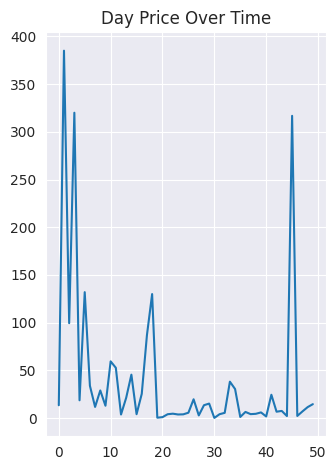

In [128]:
# min_value = egad_data_frame['Day_Of_The_Week'].min()  ------ >> display(egad_data_frame.info())

# SELECT THE 2ND COLUMN AND PLOT THE DAY PRICE AGAINST TIME

plt.subplot(1, 2, 2)  
price_column = pd.to_numeric(nsc_data_frame['Day Price'], errors='coerce')
price_column[:50].plot()
plt.title('Day Price Over Time')

plt.tight_layout()  # To improve subplot spacing
plt.show()

# preprocessed_df['Date'] =pd.to_datetime(preprocessed_df['Date'])  plt.plot(preprocessed_df['Date'], preprocessed_df['Day Price'])


In [129]:
#Custom Data cleaner 
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

nsc_scaler = StandardScaler()

class NSCDataPreProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self,company_code ,to_type_cast, to_scale, to_return):
        self.company_code = company_code        
        self.to_type_cast= to_type_cast 
        self.to_return= to_return 
        self.to_scale=to_scale  #same as  columns_to_type_cast but has the company code.
        
        
    def __type_cast_and_scale_xyz_df(self, xyz_data_frame):
        for column_name in self.to_type_cast:
            xyz_data_frame[column_name] = pd.to_numeric(xyz_data_frame[column_name], errors='coerce')
        xyz_data_frame[self.to_scale] = nsc_scaler.fit_transform(xyz_data_frame[self.to_scale])
        
        
        return xyz_data_frame[self.to_return]
    
    def fit(self, X, y=None):
        return self
       

    def transform(self, X):   
        """
        X - NSC dataFrame
        Selects the data for one company , then names it xyz_company_data_frame 
        NB: Scaler always return columns that are assignable to the dataframe.        
        """        
        
        xyz_company_data_frame = nsc_data_frame[nsc_data_frame['Code'] == self.company_code].reset_index(drop=True)
        type_converted_xyz_company_df = self.__type_cast_and_scale_xyz_df(
            xyz_company_data_frame       
        )
        
        return type_converted_xyz_company_df
    
# 'Code','Day Price','Day High', 'Day High', '12m High', '12m Low' , 'Day Price','Day High', 'Day High', '12m High', '12m Low'

random_company_code = random.choice(nsc_data_frame.Code)
    
__data_scaler = NSCDataPreProcessor(
    company_code= random_company_code,
    to_type_cast=['Day Price','Day High', 'Day Low', '12m High', '12m Low'],
    to_scale=[ 'Previous','Day High', 'Day Low', '12m High', '12m Low'],
    to_return=['Code','Day Price','Previous','Day High', 'Day Low', '12m High', '12m Low'], 
)

xyz_preprocessed_df = __data_scaler.fit_transform(
    nsc_data_frame,    
)
display(xyz_preprocessed_df)

preprocessed_df = xyz_preprocessed_df.drop(columns=['Code'])
preprocessed_df
    

,Code,Day Price,Previous,Day High,Day Low,12m High,12m Low
0,LIMT,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
1,LIMT,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
2,LIMT,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
3,LIMT,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
4,LIMT,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
...,...,...,...,...,...,...,...
97,LIMT,352,3.629627,3.339797,3.339797,-1.009494,0.0
98,LIMT,352,3.629627,3.339797,3.339797,-1.009494,0.0
99,LIMT,352,3.629627,3.339797,3.339797,-1.009494,0.0
100,LIMT,355,3.629627,3.680229,3.680229,-0.340868,0.0


,Day Price,Previous,Day High,Day Low,12m High,12m Low
0,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
1,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
2,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
3,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
4,320,-0.271296,-0.291481,-0.291481,0.773509,0.0
...,...,...,...,...,...,...
97,352,3.629627,3.339797,3.339797,-1.009494,0.0
98,352,3.629627,3.339797,3.339797,-1.009494,0.0
99,352,3.629627,3.339797,3.339797,-1.009494,0.0
100,355,3.629627,3.680229,3.680229,-0.340868,0.0


In [130]:
output_var = pd.DataFrame(preprocessed_df['Day Price'])
features = ['Previous','Day High', 'Day Low', '12m High', '12m Low']


scaler = MinMaxScaler()
feature_transform =  preprocessed_df[features]
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=preprocessed_df.index)
display(output_var)
feature_transform.head()


,Day Price
0,320
1,320
2,320
3,320
4,320
...,...
97,352
98,352
99,352
100,355


,Previous,Day High,Day Low,12m High,12m Low
0,-0.271296,-0.291481,-0.291481,0.773509,0.0
1,-0.271296,-0.291481,-0.291481,0.773509,0.0
2,-0.271296,-0.291481,-0.291481,0.773509,0.0
3,-0.271296,-0.291481,-0.291481,0.773509,0.0
4,-0.271296,-0.291481,-0.291481,0.773509,0.0


In [131]:
from sklearn.model_selection import TimeSeriesSplit
time_series_split= TimeSeriesSplit(n_splits=10) #number of splits to be 10, indicating that 10% of the data will serve as the test set


for train_index, test_index in time_series_split.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train.shape

(93, 1, 5)

In [132]:
input_shape = (X_train.shape[1],X_train.shape[2])
lstm = Sequential()
lstm.add(LSTM(100, input_shape=input_shape, activation='relu', return_sequences=True))
lstm.add(Dropout(.2))
lstm.add(LSTM(100, activation='relu', return_sequences=False))
lstm.add(Dropout(.2))
lstm.add(Dense(1))

lstm.compile(loss=MeanSquaredError(), 
              optimizer=Adam(),
              metrics=[RootMeanSquaredError()])

lstm.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 1, 100)            42400     
                                                                 
 dropout_26 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_27 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122901 (480.08 KB)
Trainable params: 122901 (480.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history=lstm.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False)

Epoch 1/200
12/12 [==============================] - 3s 5ms/step - loss: 102387.4609 - root_mean_squared_error: 319.9804
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 102354.3359 - root_mean_squared_error: 319.9286
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 102303.8203 - root_mean_squared_error: 319.8497
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 102217.9531 - root_mean_squared_error: 319.7154
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 102075.4375 - root_mean_squared_error: 319.4925
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 101824.3750 - root_mean_squared_error: 319.0993
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 101347.6328 - root_mean_squared_error: 318.3514
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 100521.5469 - root_mean_squared_error: 317.0513
Epoch 9/200
12/12 [=============

In [ ]:
predicted_stock_prices= lstm.predict(X_test)

print(X_test.shape)
print(y_test.shape)

plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_stock_prices, color = 'green', label = 'Predicted Stock Price')
plt.title(random_company_code + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



#TPSE  giving the best results .



In [ ]:
test_df = pd.DataFrame(data={'Actual Stock Prices':y_test.flatten(),'Predicted Stock Prices':predicted_stock_prices.flatten()})
test_df